In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
# Для отрисовки сетки за графиком
plt.rc('axes', axisbelow=True)

In [2]:
df = pd.read_excel('Market Data.xlsx')
df = df.drop(['Unnamed: 0'], axis = 1)
df = df[(df['Iid'] == '01')]  # | (df['Iid'] == '02')
df = df.sort_values(['GVKey', 'DataDate'])
df['new'] = df.groupby('GVKey')['MkVal'].pct_change()
df.reset_index(inplace = True)

In [3]:
stocks = pd.read_excel('my_excel_file.xlsx')
stocks = np.array(stocks['GVKey'])

In [82]:
# df.groupby(pd.Grouper(freq = 'Y', key = 'DataDate'))['trt1m'].apply(lambda x: x.isnull().sum())
Assets_table = df.pivot_table(
                  index='DataDate', 
                  columns='GVKey', 
                  values='trt1m').applymap(float)

Assets_table = Assets_table.loc[:, stocks]

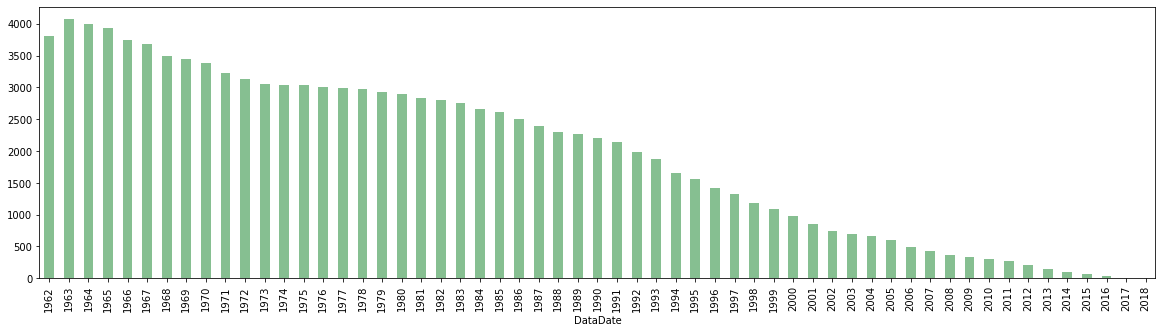

In [80]:
ax = Assets_table.groupby(pd.Grouper(freq = 'Y',
                            level = Assets_table.index.name))['NAN'].sum().plot(kind='bar', color='#86bf91', 
                            zorder=2, figsize = (20,5)) 
plt.xticks(np.arange(len(Assets_table.index.strftime('%Y').drop_duplicates())), 
           Assets_table.index.strftime('%Y').drop_duplicates(), rotation=90)
plt.show()

In [5]:
Assets_table = Assets_table.loc[Assets_table.index[450]: , :]
Assets_table.fillna(method='ffill', inplace=True)
Assets_table.fillna(method='bfill', inplace=True)

## Пример движения стоимости ряда компаний из генеральной совокупности 

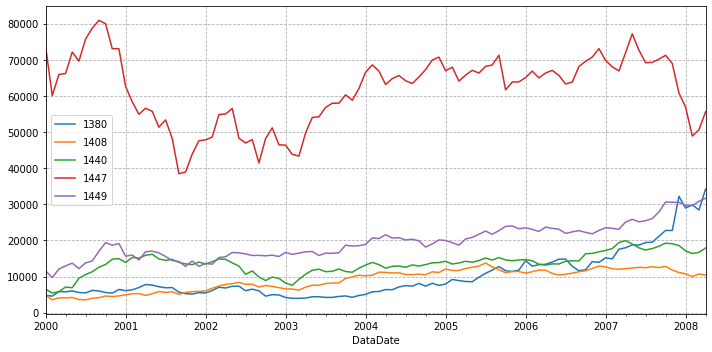

## Граница эффективности

Моделирование совокупности инвестиционных портфелей графически представляется в форме «пули», верхняя линия которой является эффективной границей. Точки, лежащие на ней, представляют собой портфели с наименьшим уровнем риска для заданной доходности. Остальные точки, находящиеся правее соответсвуют большему риску при том же показатели ожидаемой доходности

Построение эффективной границы предполагает нахождение двух крайних точек (минимального риска и максимальной доходности с учетом показателя риска). Для этого используем Scipy's optimize function как альтернативу перебору всех возможных вариантов сформированных портфелей. Scipy's optimize function сходна с функцией 'Поиск решения' в Excel, выполняет те же функции, при указании того, что нужно оптимизировать и какие при этом есть ограничения (constraints) и границы (bounds).

Ниже приведены функции для получения портфеля с наибольшим коэффициентом Шарпа. Данный показатель отражает во сколько раз уровень доходности выше уровня риска. Он указывает на стабильность прибыли, при этом отображая и ее количественную характеристику.

Поскольку в Scipy's optimize function отсутствует «максимизация» в качестве целевой функции должно быть выбрано то, что следует минимизировать. Поэтому "neg_sharpe_ratio" вычисляет отрицательный коэффициент Шарпа.

В функции "max_sharpe_ratio" сначала определяются аргументы (они не должны включать, те значения, которые будут изменяться в ходе оптимизации, в частности доли акций -"weights")

Поскольку доли акций в портфеле суммарно не должны превышать 1 (нельзя превысить бюджет более чем на 100 %) то: constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) Данное ограничение говорит о том, что сумма x должна быть равна 1.

Для лучшего понимания можно рассматривать данное условие как перенос 1 в левую сторону равенства: 'np.sum(x) == 1' has become 'np.sum(x)-1'

Границы задают другое ограничения для долей акции – они должны лежать в интервале от 0 до 1. Ведь нельзя задать отрицательное распределение ровно, как и превысить 100% показатель.

In [7]:
# Рассчитываем ожидаемый ретерн и матрицу ковариации доходностей
mean_returns = Assets_table.mean() # ожидаемый ретерн считаем, исходя из анализа фундаментальных и тех показателей, пока mean
cov_matrix = Assets_table.cov()
num_portfolios = 25000 # Кол-во расчитываемых портфелей (итераций)
risk_free_rate = 0.00 # Безрисковая процентная ставка, пока ставим 0
num_periods_annually = 12 # Количество месяцев в году

In [8]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) * num_periods_annually
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(num_periods_annually)
    return std, returns


def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    
    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        return -(p_ret - risk_free_rate) / p_var

    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


Также можно определить оптимизирующую функцию для расчета минимального показателя риска. На этот раз минимизируем целевую функцию – риск (min_variance), используя разные показатели долей акций. "Constraints" и "bounds" такие же, как и выше.

In [9]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]


def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

Как уже упоминалось выше эффективная граница — это линия, которая отражает, где находятся эффективные портфели для заданного уровня риска. Ниже приведены функции для ее вычисления. Первая - "efficient_return" вычисляет самый эффективный портфель для заданного риска, а вторая - "efficient_frontier" принимает диапазон целевых доходностей и вычисляет эффективный портфель для каждой из них.

In [10]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Построим портфель с максимальным коэффициентом Шарпа и минимальным риском, а также отразим все случайно сгенерированные портфели. При этом мы не выбираем оптимальные портфели из случайно сгенерированных, а вычисляем их, используя Scipy's 'minimize' function. Приведенная ниже функция также строит границу эффективности.

In [30]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(3)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

Оптимизируем. Ищем портфель с максимальным коэффициентом шарпа (max_sharpe) и минимальным риском (min_vol)

In [12]:
%%time
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
min_vol = min_variance(mean_returns, cov_matrix)

Wall time: 52.9 ms


In [13]:
%%time
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=Assets_table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T

Wall time: 0 ns


In [14]:
%%time
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=Assets_table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

Wall time: 5.1 ms


Находим (оптимизируем) эффективную границу портфелей

In [19]:
%%time
target = np.linspace(rp_min, 0.017, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

Wall time: 2.13 s


Преобразуем оптимизированные параметры для нормального отображения при использовании print

Генерируем (метод Монте Карло) num_portfolios случайных портфелей для отрисовки их на графике

In [31]:
%%time
results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

Wall time: 17.3 s


--------------------------------------------------------------------------------
Распределение долей акций в портфеле с максимальным коэффициентом Шарпа:n
Годовая доходность: 11.513
Годовой риск: 17.122
Коэффициент Шарпа 0.672


GVKey        2176   3336   3221
allocation  57.45  22.32  20.23
--------------------------------------------------------------------------------
Распределение долей акций в портфеле с наименьшим показателем риска:

Годовая доходность: 10.845
Годовой риск: 16.618
Коэффициент Шарпа: 0.653


GVKey        2176   3336  3221
allocation  74.07  16.35  9.58
Wall time: 443 ms


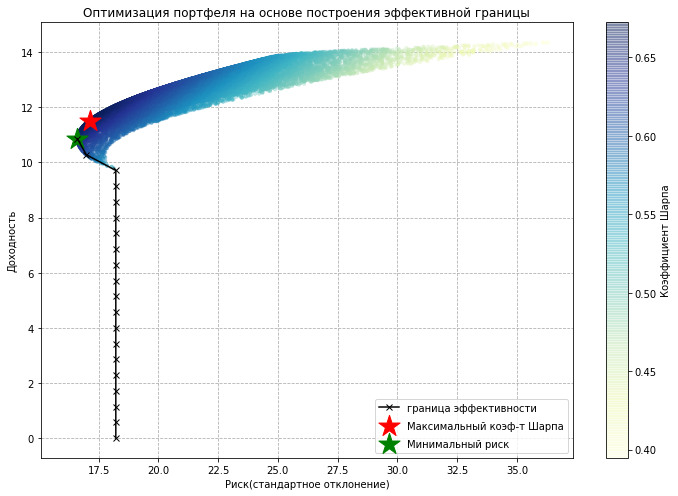

In [32]:
%%time
print("-"*80)
print("Распределение долей акций в портфеле с максимальным коэффициентом Шарпа:n")
print("Годовая доходность:", round(rp,3))
print("Годовой риск:", round(sdp,3))
print("Коэффициент Шарпа", round((rp - risk_free_rate)/sdp, 3))
print("\n")
print(max_sharpe_allocation)
print("-"*80)
print("Распределение долей акций в портфеле с наименьшим показателем риска:\n")
print("Годовая доходность:", round(rp_min,3))
print("Годовой риск:", round(sdp_min,3))
print("Коэффициент Шарпа:", round((rp_min - risk_free_rate)/sdp_min, 3))
print("\n")
print(min_vol_allocation)

plt.figure(figsize=(10, 7))
plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Коэффициент Шарпа')
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Максимальный коэф-т Шарпа')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Минимальный риск')

plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', label='граница эффективности')
plt.title('Оптимизация портфеля на основе построения эффективной границы')
plt.xlabel('Риск(стандартное отклонение)')
plt.ylabel('Доходность')
plt.grid(True, linestyle='--')
plt.legend(labelspacing=0.8)

plt.tight_layout();